<a href="https://colab.research.google.com/github/niwratti/DocEnTR/blob/main/demo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [115]:
pip install vit-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [116]:
pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
pip install vision_transformer_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [119]:
import torchvision.transforms.functional as TF
from torchvision import transforms
import torch.optim as optim
import torch.utils.data as D
from PIL import Image
from tqdm import tqdm
import numpy as np
import os
import random
from vit_pytorch import ViT
from einops import rearrange
import cv2
import matplotlib
import math
import argparse
from torch import nn
import torch.nn.functional as F
from vit_pytorch.vit import Transformer
import torch
import pathlib
import matplotlib.pyplot as plt


## Specify the configurations that you want to use to build your model

Here, pick the desired configuration depending on the weights that you downloaded from our repository. The weights can be downloaded from; https://github.com/dali92002/DocEnTR in the Section Model Zoo.

In [120]:
THRESHOLD = 0.5 ## binarization threshold after the model output
SPLITSIZE =  256  ## your image will be divided into patches of 256x256 pixels
setting = "base"  ## choose the desired model size [small, base or large], depending on the model you want to use
patch_size = 8 ## choose your desired patch size [8 or 16], depending on the model you want to use
image_size =  (SPLITSIZE,SPLITSIZE)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [121]:
if setting == 'base':
    encoder_layers = 6
    encoder_heads = 8
    encoder_dim = 768

if setting == 'small':
    encoder_layers = 3
    encoder_heads = 4
    encoder_dim = 512

if setting == 'large':
    encoder_layers = 12
    encoder_heads = 16
    encoder_dim = 1024

In [122]:
class BinModel(nn.Module):
    """
    The autoencoder model to enhance images in an image to image translation fashion.
    This code is built on top of the vit-pytorch code https://github.com/lucidrains/vit-pytorch.
    Args:
        encoder (model): the defined encoder, hete it is a ViT
        decoder_dim (int): decoder dim (embedding size)
        decoder_depth (int): number of decoder layers
        decoder_heads (int): number of decoder heads
        decoder_dim_head (int): decoder head dimension
    """
    def __init__(
        self,
        *,
        encoder,
        decoder_dim,
        decoder_depth = 1,
        decoder_heads = 8,
        decoder_dim_head = 64
    ):
        super().__init__()
        # extract hyperparameters and functions from the ViT encoder.
        self.encoder = encoder
        num_patches, encoder_dim = encoder.pos_embedding.shape[-2:]
        self.to_patch, self.patch_to_emb = encoder.to_patch_embedding[:2]
        pixel_values_per_patch = self.patch_to_emb.weight.shape[-1]

        # define your decoder here
        self.enc_to_dec = nn.Linear(encoder_dim, decoder_dim) if encoder_dim != decoder_dim else nn.Identity()
        self.mask_token = nn.Parameter(torch.randn(decoder_dim))
        self.decoder = Transformer(dim = decoder_dim, depth = decoder_depth, heads = decoder_heads, dim_head = decoder_dim_head, mlp_dim = decoder_dim * 4)
        self.decoder_pos_emb = nn.Embedding(num_patches, decoder_dim)
        self.to_pixels = nn.Linear(decoder_dim, pixel_values_per_patch)

    def forward(self, img, gt_img):
        
        # get patches and their number
        patches = self.to_patch(img)
        _, num_patches, *_ = patches.shape

        # project pixel patches to tokens and add positions
        tokens = self.patch_to_emb(patches)
        tokens = tokens + self.encoder.pos_embedding[:, 1:(num_patches + 1)]

        # encode tokens by the encoder
        encoded_tokens = self.encoder.transformer(tokens)

        # project encoder to decoder dimensions, if they are not equal.
        decoder_tokens = self.enc_to_dec(encoded_tokens)

        # decode tokens with decoder
        decoded_tokens = self.decoder(decoder_tokens)

        # project tokens to pixels
        pred_pixel_values = self.to_pixels(decoded_tokens)

        # calculate the loss with gt
        gt_patches = self.to_patch(gt_img)
        loss = F.mse_loss(pred_pixel_values, gt_patches)

        return loss, patches, pred_pixel_values

## Build your model
Build the transformer autoencoder model

In [123]:
v = ViT(
    image_size = image_size,
    patch_size = patch_size,
    num_classes = 1000,
    dim = encoder_dim,
    depth = encoder_layers,
    heads = encoder_heads,
    mlp_dim = 2048
)
model = BinModel(
    encoder = v,
    decoder_dim = encoder_dim,      
    decoder_depth = encoder_layers,
    decoder_heads = encoder_heads       
)

model = model.to(device)

## load the pretrained weights that were downloaded from our repo:
Here, give the path of the downloaded weights and load them to use a trained model.

In [124]:
model_path = r"/content/best-model_8_2011base_256_8.pt"
model.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

## Read the degraded image

Here specify the location of the degraded image that you want to clean. and then read it. We also can visualize it before cleaning. Here I have a folder named demo that contain two folders named degraded and cleaned, the degraded contain the degraded image and the cleaned will contain later the obtained results. But you can specify your own names of folders.

In [134]:
deg_image = cv2.imread('/content/X00016469619.jpg',1) / 255

In [135]:
print(deg_image.shape)

(1004, 439, 3)


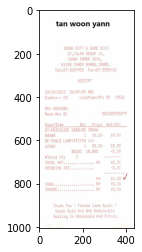

In [136]:
plt.imshow(deg_image)

## Split and Merge functions

Here, two function that are used for splitting an image into patches and merge a list of patches into an image. 

In [156]:
def split(im,h,w):
    patches=[]
    nsize1=SPLITSIZE
    nsize2=SPLITSIZE
    for ii in range(0,h,nsize1): #2048
        for iii in range(0,w,nsize2): #1536
            patches.append(im[ii:ii+nsize1,iii:iii+nsize2,:])
    
    return patches 

def merge_image(splitted_images, h,w):
    image=np.zeros(((h,w,3)))
    nsize1=SPLITSIZE
    nsize2=SPLITSIZE
    ind =0
    for ii in range(0,h,nsize1):
        for iii in range(0,w,nsize2):
            image[ii:ii+nsize1,iii:iii+nsize2,:]=splitted_images[ind]
            ind += 1
    return image  


## Preprocess the Image

Preprocess the image by dividing it into patches and get them ready to be used by the model

In [157]:
## Split the image intop patches, an image is padded first to make it dividable by the split size
h =  ((deg_image.shape[0] // 256) +1)*256 
w =  ((deg_image.shape[1] // 256 ) +1)*256
deg_image_padded=np.ones((h,w,3))
deg_image_padded[:deg_image.shape[0],:deg_image.shape[1],:]= deg_image
patches = split(deg_image_padded, deg_image.shape[0], deg_image.shape[1])

In [158]:
## preprocess the patches (images)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

out_patches=[]
for p in patches:
    out_patch = np.zeros([3, *p.shape[:-1]])
    for i in range(3):
        out_patch[i] = (p[:,:,i] - mean[i]) / std[i]
    out_patches.append(out_patch)

## Clean your image with the trained model

Clean your list of patches obe by one.

In [159]:
result = []
for patch_idx, p in enumerate(out_patches):
    print(f"({patch_idx} / {len(out_patches) - 1}) processing patch...")
    p = np.array(p, dtype='float32')
    train_in = torch.from_numpy(p)

    with torch.no_grad():
        train_in = train_in.view(1,3,SPLITSIZE,SPLITSIZE).to(device)
        _ = torch.rand((train_in.shape)).to(device)
        loss,_, pred_pixel_values = model(train_in,_)
        rec_patches = pred_pixel_values
        rec_image = torch.squeeze(rearrange(rec_patches, 'b (h w) (p1 p2 c) -> b c (h p1) (w p2)', p1 = patch_size, p2 = patch_size,  h=image_size[0]//patch_size))
        impred = rec_image.cpu().numpy()
        impred = np.transpose(impred, (1, 2, 0))
        for ch in range(3):
            impred[:,:,ch] = (impred[:,:,ch] *std[ch]) + mean[ch]
        impred[np.where(impred>1)] = 1
        impred[np.where(impred<0)] = 0
    result.append(impred)

(0 / 7) processing patch...
(1 / 7) processing patch...
(2 / 7) processing patch...
(3 / 7) processing patch...
(4 / 7) processing patch...
(5 / 7) processing patch...
(6 / 7) processing patch...
(7 / 7) processing patch...


## Get your cleaned image and save it

After cleaning the list of patches you can now merge them again to an image ang get it back to it original size by removing the padding. Here you can also vizualize your image before saving it into your desired folder.

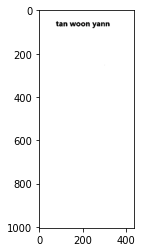

In [160]:
clean_image = merge_image(result, deg_image_padded.shape[0], deg_image_padded.shape[1])
clean_image = clean_image[:deg_image.shape[0], :deg_image.shape[1],:]
clean_image = (clean_image>THRESHOLD)*255
plt.imshow(clean_image)

In [161]:
output_dir = pathlib.Path(r'C:\Users\niwra\Desktop\MSProgram\experimentdataset\exp1cleanimages')
output_dir.mkdir(exist_ok=True)

model_name = pathlib.Path(model_path).stem
image_path = pathlib.Path('/content/X00016469619.jpg')
output_path = output_dir.joinpath(f'{image_path.stem}__{model_name}{image_path.suffix}')

cv2.imwrite(str(output_path), clean_image)
print(f'created file: {output_path}')

created file: C:\Users\niwra\Desktop\MSProgram\experimentdataset\exp1cleanimages/X00016469619__best-model_8_2011base_256_8.jpg
